# Generating flow duration and size

In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
from tqdm.notebook import tqdm

## Constants

In [3]:
BATCH_SIZE = 1300
NUM_EPOCHS = 5
LEARNING_RATE = 0.02
RANDOM_SEED = 77
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAINING_DATA = "training_data.pt"
PATH = "generator.pt"
BINS = 50

## Discriminator Class

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input is 2D, first hidden layer is composed of 256 neurons with ReLU activation
            nn.Linear(2, 128), 
            nn.ReLU(),

            # Have to use dropout to avoid overfitting
            nn.Dropout(0.3),

            # second and third layers are composed to 128 and 64 neurons, respectively
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # output is composed of a single neuron with sigmoidal activation to represent a probability
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

## Generator Class

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

## Preparing Data

In [6]:
def load_data():
    data = torch.load(TRAINING_DATA)
    data = data.to(torch.float32)
    return data

In [8]:
# Load and move training data to chosen device
train_data = load_data()
TRAINING_DATA_LENGTH = len(train_data)
train_data = train_data.to(DEVICE)

# Create labels and move to chosen device
train_labels = torch.zeros(size=(TRAINING_DATA_LENGTH, 1))
train_labels = train_labels.to(DEVICE)
                           
# Create data loader for training process
train_set = [(train_data[i], train_labels[i]) for i in range(TRAINING_DATA_LENGTH)]
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

UnpicklingError: invalid load key, '\x0d'.

In [36]:
def convert_time(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d hours %02d mins %02d secs" % (hour, minutes, seconds)

## Preparing for Training

In [37]:
# Create and move neural networks to device
generator = Generator()
discriminator = Discriminator()
generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)

# Create loss function and optimisers
loss_function = nn.BCELoss()
discriminator_optimiser = optim.Adam(discriminator.parameters(), lr = LEARNING_RATE)
generator_optimiser = optim.Adam(generator.parameters(), lr = LEARNING_RATE)

# Create empty loss lists to track values and visualise
generator_loss_values = []
discriminator_loss_values = []
epoch_count = []

## Training Process

In [39]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):

    
    # Taking the real samples of the current batch from the data loader and assign them to real_samples
    # The first dimension of the tensor has the number of elements equal to the batch size. 
    # This is the standard way of organising data in PyTorch, with each line of the tensor representing one sample from the batch.
    for n, (real_samples, _) in enumerate(tqdm(train_loader)):
        
        # DATA FOR TRAINING THE DISCRIMINATOR
        torch.manual_seed(RANDOM_SEED)
        real_samples_labels = torch.ones((BATCH_SIZE, 1), device = DEVICE)
        latent_space_samples = torch.randn((BATCH_SIZE, 2), device = DEVICE)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((BATCH_SIZE, 1), device = DEVICE)

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # TRAINING THE DISCRIMINATOR
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        discriminator_loss = loss_function(output_discriminator, all_samples_labels)
        discriminator_loss.backward()
        discriminator_optimiser.step()


        # DATA FOR TRAINING THE GENERATOR
        # Storing random data in latent_space_samples with a number of lines to equal batch_size
        torch.manual_seed(RANDOM_SEED)
        latent_space_samples = torch.randn((BATCH_SIZE, 2), device = DEVICE)

        
        # TRAINING THE GENERATOR
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        generator_loss = loss_function(output_discriminator_generated, real_samples_labels)
        generator_loss.backward()
        generator_optimiser.step()


        # Show loss
    #if n == BATCH_SIZE - 1:
    epoch_count.append(epoch)
    generator_loss_values.append(generator_loss.cpu().detach().numpy())
    discriminator_loss_values.append(discriminator_loss.cpu().detach().numpy())
    print(f"Epoch: {epoch} | D Loss: {discriminator_loss} | G Loss: {generator_loss}")

end_time = time.time()
run_time = round(end_time - start_time, 2)
converted_time = convert_time(run_time)
print(f"Training complete\nRun time for {NUM_EPOCHS} epoch(s) is {converted_time}.")

  0%|          | 0/2331 [00:00<?, ?it/s]

Epoch: 0 | D Loss: 0.6091340780258179 | G Loss: 0.8936192989349365


  0%|          | 0/2331 [00:00<?, ?it/s]

Epoch: 1 | D Loss: 0.5911793112754822 | G Loss: 0.8742303252220154


  0%|          | 0/2331 [00:00<?, ?it/s]

Epoch: 2 | D Loss: 0.5880616903305054 | G Loss: 0.8779536485671997


  0%|          | 0/2331 [00:00<?, ?it/s]

Epoch: 3 | D Loss: 0.5809561610221863 | G Loss: 0.8760620355606079


  0%|          | 0/2331 [00:00<?, ?it/s]

Epoch: 4 | D Loss: 0.8154510259628296 | G Loss: 0.8438047170639038
Training complete
Run time for 5 epoch(s) is 0 hours 02 mins 49 secs.


## Visualising Generator and Discriminator Loss

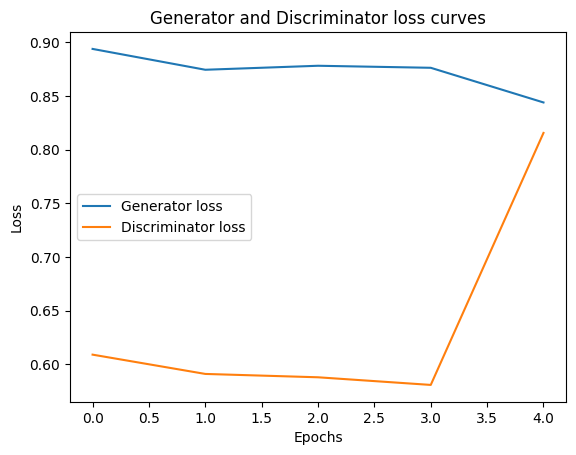

In [40]:
plt.plot(epoch_count, generator_loss_values, label="Generator loss")
plt.plot(epoch_count, discriminator_loss_values, label="Discriminator loss")
plt.title("Generator and Discriminator loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Generate synthetic data and save generator model

In [41]:
torch.manual_seed(RANDOM_SEED)
latent_space_samples = torch.randn((TRAINING_DATA_LENGTH, 2), device = DEVICE)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach().numpy()
synth_df = pd.DataFrame(generated_samples, columns = ["Duration", "Size"])
print(generated_samples)

[[  17.768526  150.72945 ]
 [ 309.4157   5492.8145  ]
 [  42.33899   694.9251  ]
 ...
 [ 119.17874  2928.9714  ]
 [ 166.72012  3195.6353  ]
 [ 101.846924 2230.609   ]]


## Visualise synthetic data

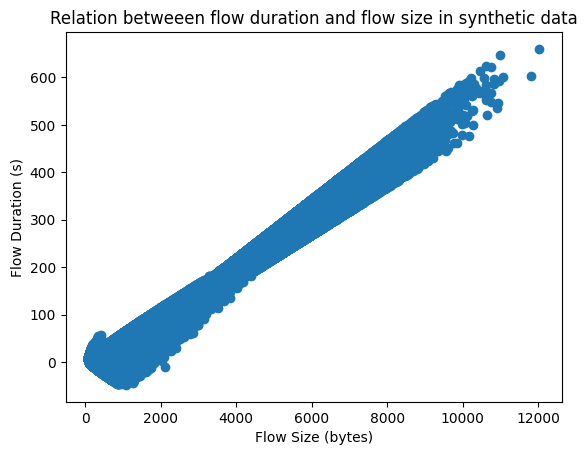

In [43]:
plt.scatter(synth_df["Size"], synth_df["Duration"])
plt.title("Relation betweeen flow duration and flow size in synthetic data")
plt.xlabel("Flow Size (bytes)")
plt.ylabel("Flow Duration (s)")
plt.show()

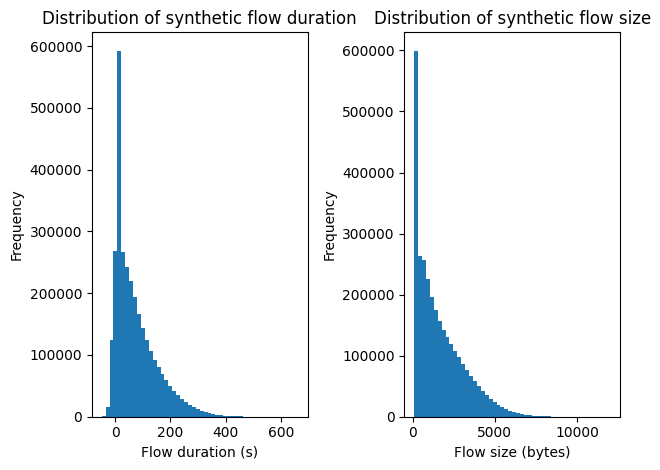

In [44]:
fig, ax = plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.hist(synth_df["Duration"], bins = BINS)
plt.title("Distribution of synthetic flow duration")
plt.xlabel("Flow duration (s)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(synth_df["Size"], bins = BINS)
plt.title("Distribution of synthetic flow size")
plt.xlabel("Flow size (bytes)")
plt.ylabel("Frequency")

fig.tight_layout()
plt.show()

## Save Generator

In [ ]:
while True:
    answer = input("Would you like to save the Generator Model? (Y or N)")
    if answer.isalpha():
        if answer.upper() == "N":
            break
        elif answer.upper() == "Y":
            torch.save(generator.state_dict(), PATH)
            print(f"Generator saved to {PATH}")
            break
        else:
            print("Enter Y or N")
    else:
        print("No numbers allowed")